In [1]:
%matplotlib inline
import os, sys, gc, argparse
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [2]:
dataDir = 'data'
loadDir = '{0}/load'.format(dataDir)
saveDir = '../figures'

# In[3]:


#parser = argparse.ArgumentParser()
##parser.add_argument("-nc", type=int)
#args = parser.parse_args()
#print(args)
#nc = args.nc

fullGuesses = np.load('{0}/test_set_master_guess_array.npy'.format(loadDir), allow_pickle = True)
humans = np.load('{0}/human_bincounts.npy'.format(dataDir))
shake = np.load('{0}/shake_shake_26_2x64d_SSI_cutout16_cifar_test_set.npz'.format(dataDir))
shakeProbs = shake['probs']
print(fullGuesses.shape)
print(humans.shape)
print(list(shake.keys()))
print(shake['labels'][:5], '\n', humans[:5])
print(np.mean(np.argmax(shakeProbs, axis = 1) == shake['labels']))
print()

(10000,)
(10000, 10)
['labels', 'logits', 'probs']
[3 8 8 0 6] 
 [[ 0  1  1 48  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 52  0]
 [38  0  8  0  1  0  1  0  2  1]
 [ 0  0  1  0  0  0 50  0  0  0]]
0.973



In [3]:
def guesses_to_probs(guesses, numCats):
    guesses = np.int_(guesses)
    hist = np.bincount(guesses, minlength = numCats)
    hist += 1 # plus one smoothing: can change
    return hist / np.sum(hist)

def flatten_guesses(fullGuesses):
    """Expects fullGuesses to be a numpy array, with each row corresponding to the guesses for each image, in order"""
    flattenedGuesses = []
    flattenedPicNums = []
    for pic, guesses in enumerate(fullGuesses):
        numGuessesPic = len(guesses)
        flattenedGuesses.append(guesses)
        flattenedPicNums.append(np.repeat(pic, numGuessesPic))
    flattenedGuesses = np.hstack(flattenedGuesses)
    flattenedPicNums = np.hstack(flattenedPicNums)

    return flattenedGuesses, flattenedPicNums

def create_prob_dist(guessArray, numCats = 10):
    """Expects guess array to have numImages rows (either by 1 (an array), or a number of guesses);
    NB plus one smoothing applied to prevent division by 0"""
    probDist = np.empty((len(guessArray), numCats))
    for pic, guesses in enumerate(guessArray):
        probDist[pic] = guesses_to_probs(guesses, numCats)
        assert np.around(np.sum(probDist[pic]), 3) == 1, 'sum of prob dist not 1: {0}'.format(np.sum(probDist[pic]))
    return probDist

def calculate_entropy_distribution(current, prior_mode):
    entropies = []
    for guesses in current:
        probs = guesses_to_probs(guesses, 10)
        ent = entropy(probs)
        entropies.append(ent)
    if 'exp' in prior_mode:
        temp = np.int(np.around(np.float(prior_mode.split('_')[-1]), 1))
        return np.exp(temp * np.array(entropies))
    else:
        return np.array(entropies)

def add_samples_from_NN(current, NNProbs, numSamples = 10):
    """Take NN probs as parameters from categorical and sample N times"""
    imNums = len(current)
    for im in np.arange(imNums):
        candidateAdd = current[im].copy()
        
       
        NNCand = NNProbs[im].copy().astype('float64')
        #print('before: {0}'.format(np.sum(NNCand)))
        
        NNCand = NNCand / np.sum(NNCand)
        #print(np.sum(NNProbsC[:-1]))
        CNNSample = np.argmax(np.random.multinomial(1, NNCand, size=numSamples), axis = 1)
        
        candidateAdd2 = np.append(candidateAdd, CNNSample)

        
        current[im] = candidateAdd2
        #print('after: {0}'.format(np.sum(NNProbsC)))
    return current
    
flattenedGuesses, flattenedPicNums = flatten_guesses(fullGuesses)
fullProbModel = create_prob_dist(fullGuesses)
print('fullProbModel shape: {0}'.format(fullProbModel.shape))

fullProbModel shape: (10000, 10)


In [4]:
print(len(fullGuesses[-1]))
print(flattenedPicNums[:51], '\n', flattenedGuesses[:51], '\n', fullGuesses[0], '\n',
     flattenedGuesses[-52:], '\n', fullGuesses[-1])

print(fullProbModel.shape, '\n', np.around(fullProbModel[0], 3), '\n', np.around(fullProbModel[-1], 3))

52
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [3 3 1 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3] 
 [3 3 1 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3] 
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] 
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
(10000, 10) 
 [0.016 0.033 0.033 0.803 0.016 0.033 0.016 0.016 0.016 0.016] 
 [0.016 0.016 0.016 0.016 0.032 0.016 0.016 0.839 0.016 0.016]


In [5]:
def print_shape_fn(term, value, activated = False):
    if activated:
        print('{0} has shape: {1}'.format(term, value.shape))
    
def detect_empty_array_fn(remaining, imNums):
    return np.asarray([True if (remaining[x].size != 0) else False for x in imNums])

# N.B. done in python for speed.
def sample_from_data(current, remaining, prior = None, numSamples = 10):
    """takes 2 lists of arrays: those forming current model, and those remaining.
    Updates current with N samples from remaining, and returns prob model and updated lists."""
    imNums = np.arange(len(current))
    valid = detect_empty_array_fn(remaining, imNums)
    imNums = imNums[valid]
    if prior is not None:
        #print('prior shape: {0}'.format(prior.shape))
        prior = prior[valid]
        # must renormalize prior
        oldPriorSum = np.sum(prior)
        prior = prior / oldPriorSum
        newPriorSum = np.sum(prior)
        assert np.around(newPriorSum, 3) == 1, "prior sum not 1: {0}".format(np.around(newPriorSum), 1)

    sampleNums = np.random.choice(imNums, size=numSamples, replace=True, p=prior)
    carried = 0
    
    for i in sampleNums:
        candidateAdd = current[i].copy()
        candidateSubtract = remaining[i].copy()
        try:
            choice = np.random.choice(candidateSubtract)
            index = np.argwhere(candidateSubtract==choice)[0][0]
            candidateAdd2 = np.append(candidateAdd, choice)

            candidateSubtract2 = np.delete(candidateSubtract, index)
            current[i] = candidateAdd2
            remaining[i] = candidateSubtract2
            
        except Exception as e:
            #print(e)
            carried += 1
            
#    if carried > 0:
#        print('n samples carried: {0}'.format(carried))
        
        
    return current, remaining, carried
    
def presample_exactly(current, remainder):
    imNums = len(current)
    
    for im in np.arange(imNums):
        candidateAdd = current[im].copy()
        candidateSubtract = remainder[im].copy()
        try:
            choice = np.random.choice(candidateSubtract)
        except:
            continue
        index = np.argwhere(candidateSubtract==choice)[0][0]
        candidateAdd2 = np.append(candidateAdd, choice)

        candidateSubtract2 = np.delete(candidateSubtract, index)
        current[im] = candidateAdd2
        remainder[im] = candidateSubtract2
    return current, remainder
#current = [[] for x in np.arange(5)]
#print(len(current), current[:5], fullGuesses[:5])

#updatedModel, updatedRemaining = sample_from_data(current, fullGuesses[:5], None, 3)
#print(len(updatedModel), updatedModel[:10], updatedRemaining[:10])
#remaining = np.asarray([np.array([0]), np.array([]), np.array([1, 2])])
#print(detect_empty_array_fn(remaining))


In [6]:
class sample_model:
    """If this is too slow, try to exponentiate and subtract logarithms"""
    def __init__(self, probDist, testPicNums, testLabels):
        """probDist should be images by categories"""
        self.probDist = probDist
        self.numImages = self.probDist.shape[0]
        self.numCats = self.probDist.shape[1]
                        
        self.testPicNums = testPicNums
        self.numTestingSamples = self.testPicNums.shape[0]
        self.testLabels = testLabels

        self.extendedProbs = self.probDist[testPicNums]
        self.likelihoodMatrix = self.create_likelihood_matrix()
        
        self.LL = self.score_model()
    def create_likelihood_matrix(self):
        """Takes picNums by categories probability distribution and gives likelihood of guesses"""
        candidateIdx = np.arange(len(self.testLabels)), np.squeeze(self.testLabels)
        #print(candidateIdx)
        candidates = self.extendedProbs[candidateIdx]
        likelihoodMatrix = self.extendedProbs / candidates[:, np.newaxis]
        #print('exponent matrix has shape: {0}'.format(exponentMatrix.shape))
        return likelihoodMatrix
    
    def score_model(self):
        """Takes sum over categories, which should be axis 1. Then takes mean over 
        samples, which should be picNums in length, axis = 0"""
        LL = - np.mean(np.log(np.sum(self.likelihoodMatrix, axis = 1)))
        #print('Final LL: {0}'.format(LL))
        return LL
    
#    def generate_predictions(self, points):
#        topPredictions = np.argmin(self.find_test_distances(self.trained, points), axis = 0)
#        #print('topPredictions has shape: {0}. Example labels: {1}'.format(topPredictions.shape, topPredictions[:5]))
#        return topPredictions
emptyModel = [[] for x in np.arange(fullProbModel.shape[0])]
ceilingModel = sample_model(fullProbModel, flattenedPicNums, flattenedGuesses)
uniformProbs = np.ones((fullProbModel.shape))/ 10
floorModel = sample_model(uniformProbs, flattenedPicNums, flattenedGuesses)
print('Floor mean LL: {0}, Ceiling mean LL: {1}'.format(floorModel.LL, ceilingModel.LL))

Floor mean LL: -2.3025850929940463, Ceiling mean LL: -0.2997856080725539


In [7]:
def full_run(startGuesses, fullGuesses, flattenedPicNums, flattenedGuesses, NNDict, 
             prior_mode = 'none', datasetIters = 50, samplesPerIter = 10000, numPreSamples = 2):
    scores = []
    current = startGuesses.copy()
    remainder = fullGuesses.copy()
    probModel = None
    if 'none' in prior_mode:
        prior = None
    carried = 0
    
    if 'CNN' in prior_mode:
        current = add_samples_from_NN(current, NNDict['probs'], NNDict['numSamples'])
    print(current[:5])
    
    if 'presample' in prior_mode:
        for n in np.arange(numPreSamples):
            current, remainder = presample_exactly(current, remainder)
            probDist = create_prob_dist(current, 10)
            probModel = sample_model(probDist, flattenedPicNums, flattenedGuesses)
            scores.append(probModel.LL)
      
    for it in np.arange(datasetIters - numPreSamples):
        #print('\n dataset iteration {0}'.format(it))
        if 'adaptive' in prior_mode:
            #print('calculating prior!')
            prior = calculate_entropy_distribution(current, prior_mode)
            topIm = np.argmax(prior)
            #fig, ax = plt.subplots(nrows = 2, ncols = 1)
            #ax[0].set_title('for im: {0}'.format(topIm))
            #ax[0].bar(np.arange(10), guesses_to_probs(current[topIm], 10))
            #ax[1].bar(np.arange(10), guesses_to_probs(fullGuesses[topIm], 10))
            #plt.show()
            #plt.close()
        current, remainder, carried = sample_from_data(current, remainder, prior = prior, numSamples = samplesPerIter)

        while carried != 0:
            #print('carries detected!: {0}'.format(carried))
            current, remainder, carried =  sample_from_data(current, remainder, prior = prior, numSamples = carried)

        probDist = create_prob_dist(current, 10)
        probModel = sample_model(probDist, flattenedPicNums, flattenedGuesses)
        scores.append(probModel.LL)
    
    return current, remainder, scores

0.1447
0
[[4.3877479e-10 4.2822510e-09 5.8334862e-08 9.9999845e-01 6.1945497e-11
  1.3867444e-06 3.0767203e-10 2.6320685e-11 2.2988432e-10 1.0318994e-11]
 [8.2601247e-08 4.4165095e-06 1.0171681e-11 1.0105802e-10 5.3056518e-12
  6.0248813e-11 3.9452081e-13 2.9449249e-11 9.9999547e-01 1.4125276e-10]
 [1.1942343e-06 1.0436801e-02 1.3872773e-09 8.4147809e-09 2.6138871e-09
  1.8238930e-09 1.2780842e-11 5.7167540e-08 9.8956150e-01 4.2204533e-07]
 [9.9999106e-01 2.1549578e-08 7.0710048e-06 1.4160242e-06 6.2045674e-11
  1.4826472e-09 3.8210140e-11 3.3304492e-10 1.0502605e-08 5.2070914e-07]
 [2.4623293e-11 3.7709205e-09 4.1862453e-08 1.8183796e-08 2.7726607e-08
  2.2735555e-10 9.9999988e-01 3.5233452e-11 1.7328451e-11 1.4439200e-10]]


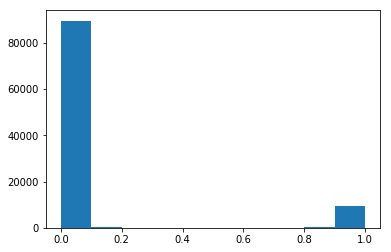

In [8]:
print(np.mean(np.sum(shakeProbs, axis = 1) > 1.0))
plt.hist(shakeProbs.ravel())
print(np.sum(shakeProbs < 0))
print(shakeProbs[:5])

In [ ]:
# uniform sampler
prior_modes = ['presample_CNN_adaptive_exp_{0}'.format(np.int(x)) for x in np.logspace(0, 7, num=7, endpoint=True, base=2.0)] 
NNDict = {'probs': shakeProbs, 'numSamples': 50}
for prior_mode in prior_modes:
    print()
    print(prior_mode)
    fig = plt.figure()
    for numPreSamples in np.arange(0, 12, 4):
        print()
        print(numPreSamples)
        postCurrent, postRemainder, scores = full_run(emptyModel.copy(), fullGuesses.copy(), 
                                                            flattenedPicNums, flattenedGuesses, 
                                                      NNDict,
                                                      prior_mode = prior_mode, numPreSamples = numPreSamples)
        scores.insert(0, floorModel.LL)

        postC = len(flatten_guesses(postCurrent)[0])
        postR  = len(flatten_guesses(postRemainder)[0])

        print(postR, postC, postR + postC, len(flattenedGuesses))


        normalizedScores = (scores - floorModel.LL) / (ceilingModel.LL - floorModel.LL)
        plt.plot(normalizedScores, label = str(numPreSamples))

    plt.ylim([0, 1])
    plt.title(prior_mode)
    plt.ylabel('Proportion of full model LL')
    plt.xlabel('Number of samples (x 10,000)')
    plt.legend()
    plt.savefig('{0}/sampling_plot_{1}_{2}.png'.format(saveDir, prior_mode, NNDict['numSamples']))
    plt.show()
#plt.xticks(np.arange(len(scores)))

[array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3.]), array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8.]), array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6.])]
411000 300000 711000 511000


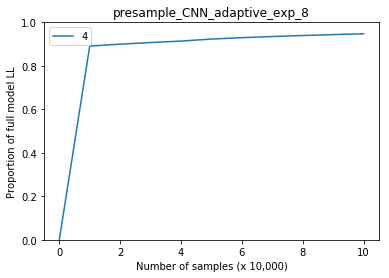

In [18]:
prior_mode = 'presample_CNN_adaptive_exp_{0}'.format(8)
NNDict = {'probs': shakeProbs, 'numSamples': 20}
numPreSamples = 4
postCurrent, postRemainder, scores = full_run(emptyModel.copy(), fullGuesses.copy(), 
                                                            flattenedPicNums, flattenedGuesses, 
                                                      NNDict,
                                                      prior_mode = prior_mode, numPreSamples = numPreSamples,
                                             datasetIters = 10)
scores.insert(0, floorModel.LL)

postC = len(flatten_guesses(postCurrent)[0])
postR  = len(flatten_guesses(postRemainder)[0])

print(postR, postC, postR + postC, len(flattenedGuesses))


normalizedScores = (scores - floorModel.LL) / (ceilingModel.LL - floorModel.LL)
plt.plot(normalizedScores, label = str(numPreSamples))

plt.ylim([0, 1])
plt.title(prior_mode)
plt.ylabel('Proportion of full model LL')
plt.xlabel('Number of samples (x 10,000)')
plt.legend()
plt.savefig('{0}/sampling_plot_{1}_NCNN_{2}.png'.format(saveDir, prior_mode, NNDict['numSamples']))
plt.savefig('{0}/sampling_plot_{1}_NCNN_{2}.pdf'.format(saveDir, prior_mode, NNDict['numSamples']))
plt.show()

In [21]:
postCurrentBinCounts = np.array([np.bincount(np.int_(x), minlength = 10) for x in postCurrent])
print(np.shape(postCurrentBinCounts), postCurrentBinCounts[:5])
np.save('{0}/{1}_CNN_{2}_soft_labels.npy'.format(loadDir, prior_mode, NNDict['numSamples']), postCurrentBinCounts)

(10000, 10) [[ 0  0  0 32  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 31  0]
 [ 0  0  0  0  0  0  0  0 27  0]
 [29  0  1  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  0 30  0  0  0]]
